2.5.1 反向传播的例子

In [39]:
import torch
x = torch.arange(4.)
x

tensor([0., 1., 2., 3.])

In [40]:
x.requires_grad_(True)
#print(x.requires_grad)
x.grad

In [41]:
y = 2 * torch.dot(x , x)  # y = 2 * x^T x
print(y)

y.backward()
x.grad

tensor(28., grad_fn=<MulBackward0>)


tensor([ 0.,  4.,  8., 12.])

In [42]:
x.grad == 4 * x 

tensor([True, True, True, True])

In [43]:
x.grad.zero_()

y = x.sum()  # y = x[0] + x[1] + x[2] + x[3]
y.backward()
x.grad

tensor([1., 1., 1., 1.])

2.5.2 非标量向量的反向传播

当y不是一个标量时，向量y关于向量x的导数的
最自然解释是一个矩阵。对于高阶和高维的y和x，
求导的结果可以是一个高阶张量。

当训练一批样本时，反向计算的和将通过对各个样本的梯度求和来获得。
此时 y , x 都是向量，y 关于 x 的导数是一个矩阵。

In [44]:
x.grad.zero_()
y = x * x   # 这是一个向量，我们模拟的多批次样本
y.sum().backward() # 必须是标量才能反向传播，y.sum()是标量
# y.backward(torch.ones(len(x))) # 等价于y.sum().backward(),需要传入和y同形状的梯度
# 表示对每个元素的梯度累加
x.grad

tensor([0., 2., 4., 6.])

2.5.3 分离计算

In [45]:

x .grad.zero_() 
y = x * x
u = y.detach()
z = u * x
z.sum().backward()
x.grad == u


tensor([True, True, True, True])

In [46]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

2.5.4 Python控制流的梯度计算

In [47]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [48]:
a = torch.randn(size=(), requires_grad=True) # a是符合正态分布的随机数
d = f(a)
d.backward(retain_graph=True)
a.grad == d / a

tensor(True)

In [49]:
print(a.grad)
a.grad.zero_()
d.backward()
print(x.grad)

tensor(8192.)
tensor([0., 2., 4., 6.])


__练习__

1.为什么计算二阶导数比一阶导数的开销要更大？

需要在计算图中保存中间结果，以便反向传播计算二阶导数。


2.在运行反向传播函数之后，立即再次运行它，看看会发生什么。

会报错，计算图在运行一次之后就被释放了。
如果需要再次运行，需要在反向传播函数中添加retain_graph=True参数。
运行两次反向传播函数，会将两次梯度相加。

In [95]:
#import torch
a = torch.randn(size=(), requires_grad=True) # a是符合正态分布的随机数
d = f(a)

d.backward(retain_graph=True)
print(a.grad)
d.backward()
print(a.grad)

tensor(16384.)
tensor(32768.)


3.在控制流的例子中，我们计算d关于a的导数，如果将变量a更改为随机向量或矩阵，会发生什么？

会报错，因为控制流的梯度计算需要将a设置为标量。
用 d.sum().backward() 代替 d.backward() 即可。

In [109]:
a = torch.randn(size=(5,5), requires_grad=True) # a是符合正态分布的随机数
d = f(a)
d.sum().backward()
print(a.grad)

tensor([[25600., 25600., 25600., 25600., 25600.],
        [25600., 25600., 25600., 25600., 25600.],
        [25600., 25600., 25600., 25600., 25600.],
        [25600., 25600., 25600., 25600., 25600.],
        [25600., 25600., 25600., 25600., 25600.]])


4.重新设计一个求控制流梯度的例子，运行并分析结果。

改成 $ y =  k a ^2 $

In [117]:
def ff(a):
    b = a*a
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:   
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)
d = ff(a)
d.backward()
print(a.grad)

tensor(-1152.9313)



5.使 $f(x)=\sin(x)$
，绘制 $f(x)$
和 $\frac{df(x)}{dx}$
 
的图像，其中后者不使用$f'(x)=\cos(x)$
。

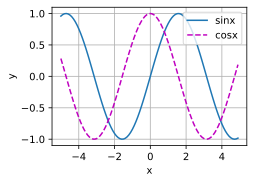

In [7]:
import torch
import numpy as np
from d2l import torch as d2l 


def f(x):
    return torch.sin(x)
x  = torch.arange(-5,5,0.1, requires_grad=True)
y = f(x)
y.sum().backward()

X = x.detach().numpy()
Y = y.detach().numpy()
X_grad = x.grad.detach().numpy()

d2l.plot(X, [Y, X_grad],'x', 'y' , legend=('sinx', 'cosx'))